In [1]:
import pandas as pd
import numpy as np
import os
import arch
import matplotlib.pyplot as plt
from baseModule.getStockData import get_stock_data
from baseModule.bayesFlexibleFourier import flexible_fourier_regression as FFR
from baseModule.dayVol import EWMA, GARCH

In [2]:
stock_RIC = "AAPL.O"

In [3]:
full_data, dayVol = get_stock_data(stock_RIC, aggre_min=10, start_time="2020-09-02 09:50:00", end_time="2021-07-31")

In [4]:
full_data

,TimeIndex,High,Low,Open,Close,Auction,Volume,Date,RIC,Vol,Vol_Day,Open_at_3:50,Auction_logdiff
0,2020-09-02 09:50:00,135.0600,132.830,133.7800,134.0601,131.40,8764850.0,2020-09-02,AAPL.O,0.002092,0.396015,131.7299,0.002508
1,2020-09-02 10:00:00,134.2000,127.000,134.0462,128.3750,131.40,15845375.0,2020-09-02,AAPL.O,0.043229,0.396015,131.7299,0.002508
2,2020-09-02 10:10:00,131.9500,128.250,128.3600,130.5201,131.40,10225981.0,2020-09-02,AAPL.O,0.016688,0.396015,131.7299,0.002508
3,2020-09-02 10:20:00,131.7500,129.900,130.5600,131.6180,131.40,5301144.0,2020-09-02,AAPL.O,0.008071,0.396015,131.7299,0.002508
4,2020-09-02 10:30:00,132.3900,131.260,131.6200,132.2300,131.40,4946475.0,2020-09-02,AAPL.O,0.004624,0.396015,131.7299,0.002508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8847,2021-07-30 15:20:00,146.2000,146.035,146.0890,146.0600,145.86,854118.0,2021-07-30,AAPL.O,0.000199,0.055316,145.9600,0.000685
8848,2021-07-30 15:30:00,146.1000,145.810,146.0518,145.9350,145.86,1178334.0,2021-07-30,AAPL.O,0.000800,0.055316,145.9600,0.000685
8849,2021-07-30 15:40:00,146.1600,145.935,145.9450,146.0500,145.86,1145037.0,2021-07-30,AAPL.O,0.000719,0.055316,145.9600,0.000685
8850,2021-07-30 15:50:00,146.0799,145.920,146.0600,145.9579,145.86,1161723.0,2021-07-30,AAPL.O,0.000699,0.055316,145.9600,0.000685


In [5]:
dayVol_model = EWMA(span=20)
dayVol["forecast"] = dayVol_model.fit(dayVol["Vol"])
dayVol_lvl = dayVol["forecast"].values[-1]

In [6]:
dayVol_train = dayVol["Vol"][-10:]
vol_train = full_data[-10*39:].Vol
vol_train = vol_train.values.reshape(39, 10)

In [7]:
fourier_model = FFR(N=39, di=[], J=5, P=12)
res = fourier_model.train(vol_train, dayVol_train, tol=1e-6)
print("Model fit success: {}".format(res.success))

Model fit success: True


In [8]:
vol_true, dayVol_true = get_stock_data(stock_RIC, aggre_min=10, start_time="2021-07-31", end_time="2021-08-03")
bayes_dayVol = fourier_model.vol_update(vol_true.Vol.values[0:20], dayVol_lvl, tol=1e-7)

Model fit success: True


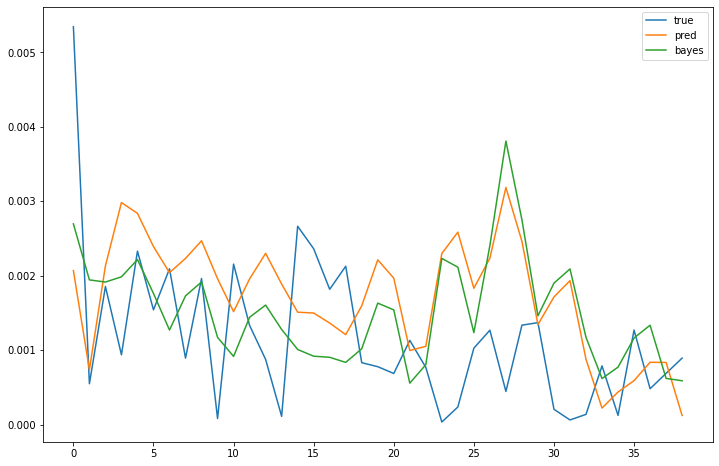

In [9]:
result = fourier_model.predict(dayVol_lvl)
bayes_result = fourier_model.predict(bayes_dayVol)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(vol_true.Vol, label="true")
ax.plot(result, label="pred")
ax.plot(bayes_result, label="bayes")
plt.legend()